# Runtime measurements

## Preparations

In [65]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import glob
import yaml
import timeit
import math

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1, style='white')

In [66]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [67]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [68]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"
mapping01["param__func__de.upb.lb-nginx.0.1__mem_max"] = "Memory"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"
mapping03["param__func__de.upb.px-squid.0.1__mem_max"] = "Memory"

web1 = select_and_rename(web1, mapping01)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [69]:
# select sub-datasets with small and large flows
# and with specific memory
mem = 128

web1_small = web1.loc[(web1["size"] == "small") & (web1["Memory"] == mem)]
web1_small = web1_small[["Max. throughput [kB/s]", "CPU"]]
web3_small = web3.loc[(web3["size"] == "small")  & (web3["Memory"] == mem)]
web3_small = web3_small[["Max. throughput [kB/s]", "CPU"]]

# add 20 "measurements" at 0 CPU and throuhgput
num_measures = 20
measures = [0 for _ in range(num_measures)]
web1_small = web1_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)
web3_small = web3_small.append(pd.DataFrame({'Max. throughput [kB/s]': measures, 'CPU': measures}), ignore_index=True)

In [70]:
def prepare_data(data):
    """Split return data"""
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X = X.fillna(X.median())

    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    
    return X, y

In [99]:
def barplot(times, labels, ylabel='Time [s]', filename=None):
    assert len(times) == len(labels)
    
    times_mean = [np.array(t).mean() for t in times]
    print(times_mean)
    times_std = [np.array(t).std() for t in times]
    x = np.arange(len(labels))
    
    sns.set(font_scale=1.5, style='white')
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(x, times_mean, yerr=times_std, capsize=5, color='gray')
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)
    
    if filename is not None:
        fig.savefig(f'plots/{filename}.pdf', bbox_inches='tight')

In [92]:
def comparison_barplot(times_squid, times_nginx, labels, ylabel='Time [s]', filename=None):
    sns.set(font_scale=1.2, style='white')
    assert len(times_squid) == len(times_nginx) == len(labels)
    
    x = np.arange(len(labels))
    width = 0.35

    # plot
    fig, ax = plt.subplots(figsize = (8, 5))
    plt.bar(x - width/2, times_squid, width, color='gray', label='Squid')
    plt.bar(x + width/2, times_nginx, width, color='lightgray', label='Nginx')
        
    # labels
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    if filename is not None:
        fig.savefig(f'plots/{filename}.pdf', bbox_inches='tight')

In [73]:
# prepare data
X_nginx, y_nginx = prepare_data(web1_small)
X_squid, y_squid = prepare_data(web3_small)

X = X_nginx
y = y_nginx
vnf_name = 'nginx'

## Training time

In [74]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark(n):
    """Generate n synthetic benchmark results for CPU time 0-100%"""
    cpu_list = [random.random() for _ in range(n)]
    thr_list = [gen_benchmark(cpu, coeff2=100) for cpu in cpu_list]
    X = pd.DataFrame(data={'Throughput': thr_list})
    y = np.array(cpu_list)
    return X, y

In [75]:
def training_times(models, X, y, scaler):
    # measure training times
    times = []
    for model in models:
        print(type(model).__name__)
        X_scaled = scaler.transform(X)
        t = %timeit -o model.fit(X, y)
        # save the best time, which is the most comparable and reproducible
        times.append(t)
    return times

In [76]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
models = [LinearRegression(), Ridge(), SVR(verbose=True), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
          FixedModel(fixed_value=0.8)]
model_names = [type(model).__name__ for model in models]
models = [joblib.load(f'ml_models/{vnf_name}/{name}.joblib') for name in model_names]
scaler = joblib.load(f'ml_models/{vnf_name}/scaler.joblib')

# X_rand = pd.DataFrame(data={'Rand max. throughput': [random.randrange(0, 3000) for _ in range(100000)]})
# y_rand = np.array([random.random() for _ in range(100000)])

# X_synth, y_synth = synthetic_benchmark(200000)

# times = training_times(models, X_synth, y_synth, scaler)

In [77]:
# # plot
# # timeit runs 7 runs with variable number of loops; calc time per loop for each run of each model
# all_times = [[i / t.loops for i in t.all_runs] for t in times]
# barplot(all_times, labels)

## Prediction time

In [78]:
# load trained models and scaler
# model_names = [type(model).__name__ for model in models]
models = [joblib.load(f'ml_models/{vnf_name}/{name}.joblib') for name in model_names]
scaler = joblib.load(f'ml_models/{vnf_name}/scaler.joblib')

In [79]:
# time single prediction for rand input
X_rand = pd.DataFrame(data={'Rand max. throughput': [random.randrange(0, 3000) for _ in range(1)]})
times = []
for model in models:
    print(type(model).__name__)
    X_scaled = scaler.transform(X_rand)
    t = %timeit -o model.predict(X_scaled)
    # save the best time, which is the most comparable and reproducible
    times.append(t)

LinearRegression
41.9 µs ± 877 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Ridge
42 µs ± 875 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
SVR
59.5 µs ± 527 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
RandomForestRegressor
891 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
GradientBoostingRegressor
107 µs ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
MLPRegressor
66.4 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
FixedModel
946 ns ± 34.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


[0.041868121428571416, 0.04201067571428731, 0.059522719999998634, 0.8912386999999821, 0.10723779999999741, 0.06644656000000201, 0.0009462411285714519]


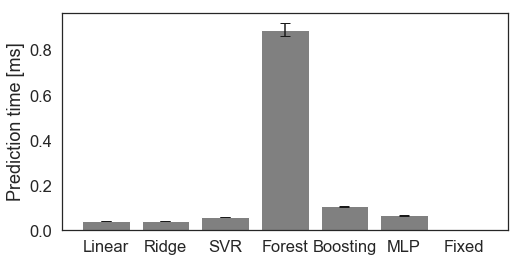

In [100]:
all_times_ms = [[i * 1000.0 / t.loops for i in t.all_runs] for t in times]
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']

barplot(all_times_ms, labels, ylabel="Prediction time [ms]", filename='prediction_times')

In [81]:
for model in models:
    print(model)
    
# reasons for relatively high prediction time of random forrest - in contrast to gradient boosting 
# both tree-based ensemble methods; both n_estimators=10 --> same number of decision trees
# unlimited max_depth of forest; max_depth 3 for gradient boosting --> deeper decision trees

# mlp is fast because it's pretty shallow (128,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=3,
                    

## Placement times

In [82]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, flow_dr=250):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(placement['input']['num_flows'])
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['source_dr'].append(placement['input']['num_flows'] * flow_dr)
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'source_dr': [], 'num_instances': [], 
            'max_e2e_delay': [], 'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f)
            data = read_placement(placement, data)

    return pd.DataFrame(data).sort_values(by=['num_flows'])

In [83]:
# read results
dataset = 'web_data'
sources = 'runtime'
results = f'placement_data/{dataset}/{sources}/'

df_true = read_results(results + 'true/*.yaml')
df_fixed = read_results(results + 'fixed/*.yaml')
df_linear = read_results(results + 'linear/*.yaml')
df_boost = read_results(results + 'boosting/*.yaml')
df_svr = read_results(results + 'svr/*.yaml')
df_ml = read_results(results + 'ml/*.yaml')

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\ipykernel_launcher.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


[1.319931435585022, 1.0002400318781535, 1.2721559921900432]


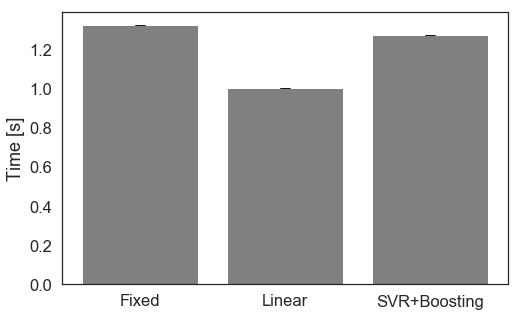

In [84]:
placement_times = [df_fixed['runtime'].mean(), df_linear['runtime'].mean(), df_ml['runtime'].mean()]
labels = ['Fixed', 'Linear', 'SVR+Boosting']

placement_times

barplot(placement_times, labels)